```Jupyter
import sys
import os
import types
import warnings
import glob
import regex as re
import netCDF4 as nc
import rasterio
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
import ipywidgets as widgets
import matplotlib.ticker as mticker
import chardet
import pyperclip
from geopandas import GeoDataFrame
from shapely.geometry import Point
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from rasterio.transform import from_origin
from rasterstats import zonal_stats
from shapely.geometry import LineString
from matplotlib.path import Path
from matplotlib.colors import Normalize
from netCDF4 import Dataset
from pyproj import CRS
from IPython.display import display
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from _windbreaks_helpers import *
```

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import chardet
import geopandas as gpd
import glob
import holoviews as hv
import hvplot.xarray
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pyperclip
import rasterio
import regex as re
import seaborn as sns
import sys
import types
import warnings
import xarray as xr
from IPython.display import display
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from geopandas import GeoDataFrame
from matplotlib.colors import Normalize
from matplotlib.path import Path
from netCDF4 import Dataset
from pyproj import CRS
from rasterio.transform import from_origin
from rasterstats import zonal_stats
from shapely.geometry import LineString
from shapely.geometry import Point

from _windbreaks_helpers import *

In [21]:
warnings.filterwarnings('ignore')
# %store -r src_dir
# %store -r extent_coords
# %store -r ksne_data
# # %store -r stormbuf_gdf
# %store -r ksne_gdf
# # %store -r crop_cvr_gdf
# %store -r ksne_se_count_gdf

## Set data source variables

In [22]:
# Path to the directory
directory = 'Data'

# Check if the directory exists
if os.path.isdir(directory):
    src_dir = directory
else:
    src_dir = None

print(src_dir)
%store src_dir

Data
Stored 'src_dir' (str)


# Preprocess Crop Loss Data

In [53]:
df = pd.read_csv(os.path.join(src_dir, 'crop_loss_COL/colsom_2019_raw.csv'))

In [63]:
# years = [str(year) for year in range(2014, 2020)]
states = ['KS', 'NE', 'SD', 'ND']
# crop_data = combine_files(src_dir+'/_alldata', years, states)
ksnesdnd_cl = df[df['State Abbreviation'].isin(states)]
ksnesdnd_cl.to_csv(os.path.join(src_dir, 'crop_loss_COL/colsom_2019_ksnesdnd_raw.csv'))

In [67]:
ksnesdnd_cl.head(10000)

,Commodity Year Identifier,FIPS,State Code,State Abbreviation,County Code,County Name,Commodity Code,Commodity Name,Insurance Plan Code,Insurance Plan Name Abbreviation,...,Liability,Total Premium,Producer Paid Premium,Subsidy,State/Private Subsidy,Additional Subsidy,EFA Premium Discount,Net Determined Quantity,Indemnity Amount,Loss Ratio
39733,2019,20001,20,KS,1,Allen,11,Wheat,2,RP,...,27267.00,3689.00,849.00,2840.00,0.0,0,0,130.099600,2601.00,0.71
39734,2019,20001,20,KS,1,Allen,11,Wheat,2,RP,...,9800.00,2227.00,512.00,1715.00,0.0,0,0,86.230000,9800.00,4.40
39735,2019,20001,20,KS,1,Allen,11,Wheat,2,RP,...,33174.10,8204.34,1944.60,6259.74,0.0,0,0,349.674502,32682.97,3.98
39736,2019,20001,20,KS,1,Allen,11,Wheat,2,RP,...,5531.00,656.00,269.00,387.00,0.0,0,0,73.000000,1936.00,2.95
39737,2019,20001,20,KS,1,Allen,11,Wheat,2,RP,...,12439.00,2059.00,927.00,1132.00,0.0,0,0,82.400000,4099.00,1.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49728,2019,20191,20,KS,191,Sumner,91,Barley,1,YP,...,30.00,7.00,3.00,4.00,0.0,0,0,0.780000,11.00,1.57
49729,2019,20193,20,KS,193,Thomas,11,Wheat,2,RP,...,40769.00,18000.00,8050.00,9950.00,0.0,0,0,345.920000,6092.00,0.34
49730,2019,20193,20,KS,193,Thomas,11,Wheat,2,RP,...,7189.00,1553.00,699.00,854.00,0.0,0,0,36.800000,414.00,0.27
49731,2019,20193,20,KS,193,Thomas,11,Wheat,2,RP,...,42795.35,6404.74,2661.92,3742.82,0.0,0,0,245.204700,5350.27,0.84


In [26]:
# ksnesdnd_cl = remove_outliers(ksnesdnd_cl, 'Year of Loss')
# sns.distplot(ksnesdnd_cl['Year of Loss'], bins=10, kde_kws={'shade': True})

In [27]:
# get column names with their index
print('\n', 'ksnesdnd_cl columns:', '\n')
print_cols(ksnesdnd_cl)


 ksnesdnd_cl columns: 

Index: 0, Column Name: Commodity Year Identifier, Data Type: int64
Index: 1, Column Name: FIPS, Data Type: int64
Index: 2, Column Name: State Code, Data Type: int64
Index: 3, Column Name: State Abbreviation, Data Type: object
Index: 4, Column Name: County Code, Data Type: int64
Index: 5, Column Name: County Name, Data Type: object
Index: 6, Column Name: Commodity Code, Data Type: int64
Index: 7, Column Name: Commodity Name, Data Type: object
Index: 8, Column Name: Insurance Plan Code, Data Type: int64
Index: 9, Column Name: Insurance Plan Name Abbreviation, Data Type: object
Index: 10, Column Name: Coverage Category, Data Type: object
Index: 11, Column Name: Stage Code, Data Type: object
Index: 12, Column Name: Cause of Loss Code, Data Type: object
Index: 13, Column Name: Cause of Loss Description, Data Type: object
Index: 14, Column Name: Month of Loss, Data Type: int64
Index: 15, Column Name: Month of Loss Name, Data Type: object
Index: 16, Column Name: Year 

In [28]:
numbers = [7, 8, 9, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
numbers_plus_one = [number + 1 for number in numbers]
print(numbers_plus_one)

[8, 9, 10, 11, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30]


In [29]:

columns_to_drop = ksnesdnd_cl.columns[[0, 8, 9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30]]
ksnesdnd_cl = ksnesdnd_cl.drop(columns=columns_to_drop)

In [30]:
# get column names with their index
print('\n', 'ksnesdnd_cl columns:', '\n')
print_cols(ksnesdnd_cl)


 ksnesdnd_cl columns: 

Index: 0, Column Name: FIPS, Data Type: int64
Index: 1, Column Name: State Code, Data Type: int64
Index: 2, Column Name: State Abbreviation, Data Type: object
Index: 3, Column Name: County Code, Data Type: int64
Index: 4, Column Name: County Name, Data Type: object
Index: 5, Column Name: Commodity Code, Data Type: int64
Index: 6, Column Name: Commodity Name, Data Type: object
Index: 7, Column Name: Cause of Loss Code, Data Type: object
Index: 8, Column Name: Cause of Loss Description, Data Type: object
Index: 9, Column Name: Month of Loss, Data Type: int64
Index: 10, Column Name: Month of Loss Name, Data Type: object
Index: 11, Column Name: Year of Loss, Data Type: float64
Index: 12, Column Name: Indemnity Amount, Data Type: float64



In [31]:
ksnesdnd_cl = ksnesdnd_cl.rename(columns={
    'Month of Loss': 'month',
    'Month of Loss Name': 'mo_name',
    'Year of Loss': 'year',
    'State Abbreviation': 'st_abb',
    'State Code': 'st_code',
    'County Code': 'co_code',
    'County Name': 'co_name',
    'Commodity Name': 'crop_name',
    'Commodity Code': 'crop_code',
    'Cause of Loss Code': 'col_code',
    'Cause of Loss Description': 'col_des',
    'Indemnity Amount': 'indemnity'
})
# Create 'fips' column by concatenating 'State Code' and 'County Code'
ksnesdnd_cl['fips'] = ksnesdnd_cl['st_code'].astype(str).str.zfill(2) + ksnesdnd_cl['co_code'].astype(str).str.zfill(3)

# Create 'yrmo' column by concatenating 'Year of Loss' and 'Month of Loss'
ksnesdnd_cl['yrmo'] = ksnesdnd_cl['year'].astype(int).astype(str) + ksnesdnd_cl['month'].astype(
    str).str.zfill(2)
ksnesdnd_cl.head()

,FIPS,st_code,st_abb,co_code,co_name,crop_code,crop_name,col_code,col_des,month,mo_name,year,indemnity,fips,yrmo
39733,20001,20,KS,1,Allen,11,Wheat,1,Decline in Price,7,JUL,2019.0,2601.00,20001,201907
39734,20001,20,KS,1,Allen,11,Wheat,11,Drought,11,NOV,2018.0,9800.00,20001,201811
39735,20001,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,11,NOV,2018.0,32682.97,20001,201811
39736,20001,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,11,NOV,2018.0,1936.00,20001,201811
39737,20001,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,7,JUL,2019.0,4099.00,20001,201907


In [32]:
# Find wind related records
wind_related = ['61', '62', '64']
wind_rel_df = ksnesdnd_cl[ksnesdnd_cl['col_code'].isin(wind_related)]
wind_rel_df.head()

,FIPS,st_code,st_abb,co_code,co_name,crop_code,crop_name,col_code,col_des,month,mo_name,year,indemnity,fips,yrmo
39822,20003,20,KS,3,Anderson,11,Wheat,61,Wind/Excess Wind,6,JUN,2019.0,6063.9,20003,201906
39977,20007,20,KS,7,Barber,11,Wheat,62,Hot Wind,7,JUL,2019.0,1251.0,20007,201907
39985,20007,20,KS,7,Barber,21,Cotton,61,Wind/Excess Wind,6,JUN,2019.0,8664.5,20007,201906
39992,20007,20,KS,7,Barber,41,Corn,61,Wind/Excess Wind,9,SEP,2019.0,1888.0,20007,201909
39993,20007,20,KS,7,Barber,41,Corn,61,Wind/Excess Wind,8,AUG,2019.0,1198.0,20007,201908


In [33]:
unique_counts = wind_rel_df['col_code'].value_counts()
print(unique_counts)


col_code
61    834
62    229
64     16
Name: count, dtype: int64


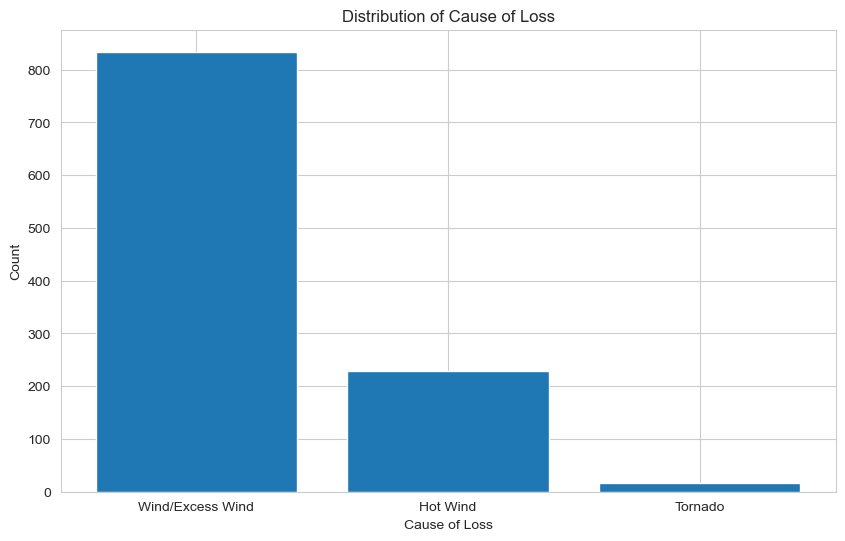

In [34]:
wr_cl = wind_rel_df
# Get unique counts
unique_counts = wr_cl['col_des'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_counts.index, unique_counts.values)

plt.xlabel('Cause of Loss')
plt.ylabel('Count')
plt.title('Distribution of Cause of Loss')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility if needed

plt.show()


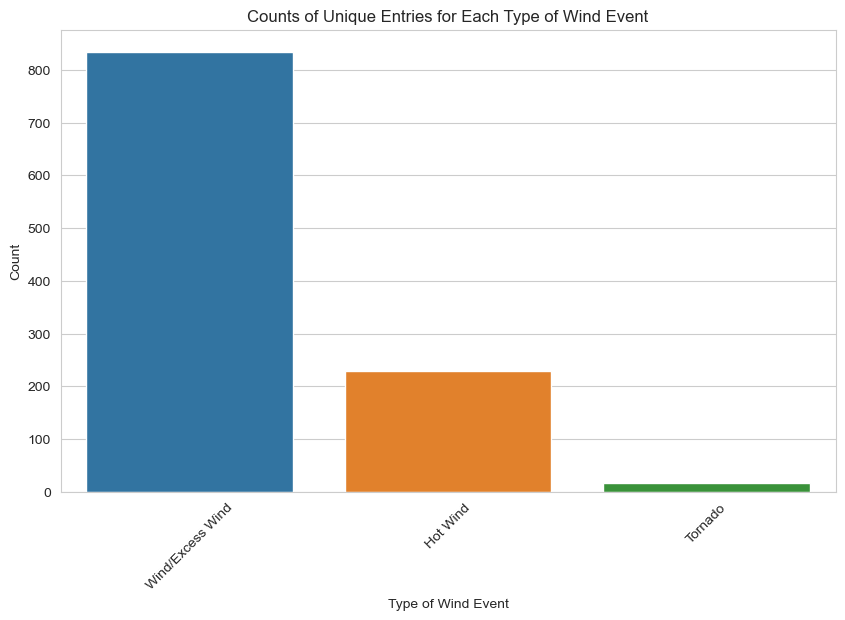

In [35]:
unique_counts = wr_cl['col_des'].value_counts()

# Convert the Series to DataFrame and reset index
unique_counts_df = unique_counts.reset_index()
unique_counts_df.columns = ['col_des', 'count']

# Plot the counts of unique entries
plt.figure(figsize=(10, 6))
sns.barplot(x='col_des', y='count', data=unique_counts_df)

plt.title('Counts of Unique Entries for Each Type of Wind Event')
plt.xlabel('Type of Wind Event')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

In [36]:
cp1_wr_cl = wr_cl
# Capitals dictionary
us_state_abbrev_upper = {
    'ALABAMA': 'AL',
    'ALASKA': 'AK',
    'AMERICAN SAMOA': 'AS',
    'ARIZONA': 'AZ',
    'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA',
    'COLORADO': 'CO',
    'CONNECTICUT': 'CT',
    'DELAWARE': 'DE',
    'DISTRICT OF COLUMBIA': 'DC',
    'FLORIDA': 'FL',
    'GEORGIA': 'GA',
    'GUAM': 'GU',
    'HAWAII': 'HI',
    'IDAHO': 'ID',
    'ILLINOIS': 'IL',
    'INDIANA': 'IN',
    'IOWA': 'IA',
    'KANSAS': 'KS',
    'KENTUCKY': 'KY',
    'LOUISIANA': 'LA',
    'MAINE': 'ME',
    'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI',
    'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO',
    'MONTANA': 'MT',
    'NEBRASKA': 'NE',
    'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH',
    'NEW JERSEY': 'NJ',
    'NEW MEXICO': 'NM',
    'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC',
    'NORTH DAKOTA': 'ND',
    'NORTHERN MARIANA ISLANDS': 'MP',
    'OHIO': 'OH',
    'OKLAHOMA': 'OK',
    'OREGON': 'OR',
    'PENNSYLVANIA': 'PA',
    'PUERTO RICO': 'PR',
    'RHODE ISLAND': 'RI',
    'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD',
    'TENNESSEE': 'TN',
    'TEXAS': 'TX',
    'UTAH': 'UT',
    'VERMONT': 'VT',
    'VIRGIN ISLANDS': 'VI',
    'VIRGINIA': 'VA',
    'WASHINGTON': 'WA',
    'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI',
    'WYOMING': 'WY'
}

# Inverse the dictionary for easier mapping.
abbrev_us_state_upper = {v: k for k, v in us_state_abbrev_upper.items()}

wr_cl['state'] = wr_cl['st_abb'].map(abbrev_us_state_upper)
wr_cl.head()

,FIPS,st_code,st_abb,co_code,co_name,crop_code,crop_name,col_code,col_des,month,mo_name,year,indemnity,fips,yrmo,state
39822,20003,20,KS,3,Anderson,11,Wheat,61,Wind/Excess Wind,6,JUN,2019.0,6063.9,20003,201906,KANSAS
39977,20007,20,KS,7,Barber,11,Wheat,62,Hot Wind,7,JUL,2019.0,1251.0,20007,201907,KANSAS
39985,20007,20,KS,7,Barber,21,Cotton,61,Wind/Excess Wind,6,JUN,2019.0,8664.5,20007,201906,KANSAS
39992,20007,20,KS,7,Barber,41,Corn,61,Wind/Excess Wind,9,SEP,2019.0,1888.0,20007,201909,KANSAS
39993,20007,20,KS,7,Barber,41,Corn,61,Wind/Excess Wind,8,AUG,2019.0,1198.0,20007,201908,KANSAS


In [37]:
# get column names with their index
print('\n', 'wr_cl columns:', '\n')
print_cols(wr_cl)


 wr_cl columns: 

Index: 0, Column Name: FIPS, Data Type: int64
Index: 1, Column Name: st_code, Data Type: int64
Index: 2, Column Name: st_abb, Data Type: object
Index: 3, Column Name: co_code, Data Type: int64
Index: 4, Column Name: co_name, Data Type: object
Index: 5, Column Name: crop_code, Data Type: int64
Index: 6, Column Name: crop_name, Data Type: object
Index: 7, Column Name: col_code, Data Type: object
Index: 8, Column Name: col_des, Data Type: object
Index: 9, Column Name: month, Data Type: int64
Index: 10, Column Name: mo_name, Data Type: object
Index: 11, Column Name: year, Data Type: float64
Index: 12, Column Name: indemnity, Data Type: float64
Index: 13, Column Name: fips, Data Type: object
Index: 14, Column Name: yrmo, Data Type: object
Index: 15, Column Name: state, Data Type: object



In [38]:
cp2_wr_cl = wr_cl
# specify the new column order
column_order = ['yrmo', 'fips', 'year', 'month', 'mo_name', 
                'st_abb', 'st_code', 'state', 'co_code', 
                'co_name', 'crop_name', 'crop_code', 
                'col_des', 'col_code', 'indemnity']

# reindex the dataframe
wr_cl = wr_cl[column_order]

In [39]:
print('\n', 'wr_cl columns:', '\n')
# get column names with their index
print_cols(wr_cl)


 wr_cl columns: 

Index: 0, Column Name: yrmo, Data Type: object
Index: 1, Column Name: fips, Data Type: object
Index: 2, Column Name: year, Data Type: float64
Index: 3, Column Name: month, Data Type: int64
Index: 4, Column Name: mo_name, Data Type: object
Index: 5, Column Name: st_abb, Data Type: object
Index: 6, Column Name: st_code, Data Type: int64
Index: 7, Column Name: state, Data Type: object
Index: 8, Column Name: co_code, Data Type: int64
Index: 9, Column Name: co_name, Data Type: object
Index: 10, Column Name: crop_name, Data Type: object
Index: 11, Column Name: crop_code, Data Type: int64
Index: 12, Column Name: col_des, Data Type: object
Index: 13, Column Name: col_code, Data Type: object
Index: 14, Column Name: indemnity, Data Type: float64



In [40]:
wr_cl['co_name'] = wr_cl['co_name'].str.upper()
wr_cl['crop_name'] = wr_cl['crop_name'].str.upper()
wr_cl['col_des'] = wr_cl['col_des'].str.upper()
wr_cl.head()

,yrmo,fips,year,month,mo_name,st_abb,st_code,state,co_code,co_name,crop_name,crop_code,col_des,col_code,indemnity
39822,201906,20003,2019.0,6,JUN,KS,20,KANSAS,3,ANDERSON,WHEAT,11,WIND/EXCESS WIND,61,6063.9
39977,201907,20007,2019.0,7,JUL,KS,20,KANSAS,7,BARBER,WHEAT,11,HOT WIND,62,1251.0
39985,201906,20007,2019.0,6,JUN,KS,20,KANSAS,7,BARBER,COTTON,21,WIND/EXCESS WIND,61,8664.5
39992,201909,20007,2019.0,9,SEP,KS,20,KANSAS,7,BARBER,CORN,41,WIND/EXCESS WIND,61,1888.0
39993,201908,20007,2019.0,8,AUG,KS,20,KANSAS,7,BARBER,CORN,41,WIND/EXCESS WIND,61,1198.0


In [41]:
unique_col_des = wr_cl['col_des'].unique()
for value in unique_col_des:
    print(value)

WIND/EXCESS WIND
HOT WIND
TORNADO


In [42]:
db4_wr_cl = wr_cl
wr_cl_col_all = wr_cl
wr_cl = wr_cl[wr_cl['col_des'].isin(['WIND/EXCESS WIND', 'HOT WIND', 'TORNADO'])]
filter_col_des = wr_cl['col_des'].unique()
for value in filter_col_des:
    print(value)

WIND/EXCESS WIND
HOT WIND
TORNADO


In [43]:
for col in wr_cl.columns:

    # If the current column's data type is float and column is not 'Indemnity', convert to int first
    if wr_cl[col].dtype == 'float64' and col != 'indemnity':
        wr_cl[col] = wr_cl[col].astype(int)

    # If column is not 'Indemnity', convert to object
    if col != 'indemnity':
        wr_cl[col] = wr_cl[col].astype('object')
# strip extra spaces
wr_cl = wr_cl.applymap(lambda x: x.strip() if isinstance(x, str) else x)
wr_cl.head()

,yrmo,fips,year,month,mo_name,st_abb,st_code,state,co_code,co_name,crop_name,crop_code,col_des,col_code,indemnity
39822,201906,20003,2019,6,JUN,KS,20,KANSAS,3,ANDERSON,WHEAT,11,WIND/EXCESS WIND,61,6063.9
39977,201907,20007,2019,7,JUL,KS,20,KANSAS,7,BARBER,WHEAT,11,HOT WIND,62,1251.0
39985,201906,20007,2019,6,JUN,KS,20,KANSAS,7,BARBER,COTTON,21,WIND/EXCESS WIND,61,8664.5
39992,201909,20007,2019,9,SEP,KS,20,KANSAS,7,BARBER,CORN,41,WIND/EXCESS WIND,61,1888.0
39993,201908,20007,2019,8,AUG,KS,20,KANSAS,7,BARBER,CORN,41,WIND/EXCESS WIND,61,1198.0


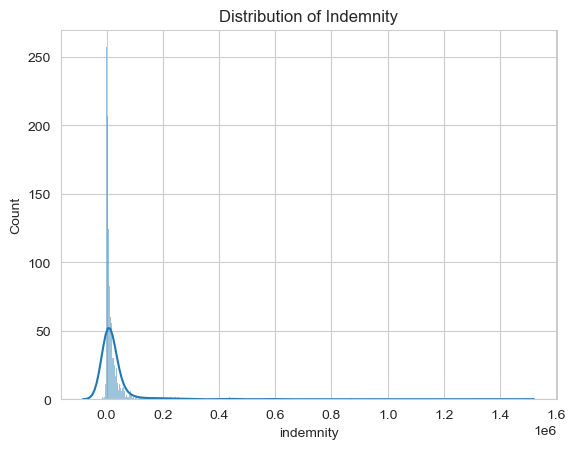

In [44]:
# Create a histogram of the 'indemnity' column
sns.histplot(data=wr_cl, x='indemnity', kde=True)

plt.title('Distribution of Indemnity')
plt.show()

In [45]:
# Start Outlier identification and removal methods
wr_cl_orig = wr_cl

# Filter out negative indemnity values
wr_cl_positive = wr_cl_orig[wr_cl_orig['indemnity'] >= 0].sort_values(by='indemnity').reset_index(drop=True)

# Calculate the differences between consecutive indemnity values
diffs = wr_cl_positive['indemnity'].diff()

# Identify the largest difference
largest_gap_index = diffs.idxmax()
largest_gap_value = diffs.max()

# Print the largest gap and the indemnity values around the gap
print('The largest gap is:', largest_gap_value)

print('The indemnity value just before the gap is:', wr_cl_positive.loc[largest_gap_index - 1, 'indemnity'])
print('The indemnity value just after the gap is:', wr_cl_positive.loc[largest_gap_index, 'indemnity'])


The largest gap is: 557928.23
The indemnity value just before the gap is: 933300.0
The indemnity value just after the gap is: 1491228.23


Indemnity values pre-standard deviation method outlier removal: 
count    1.079000e+03
mean     2.944987e+04
std      9.646561e+04
min     -8.339400e+04
25%      2.098250e+03
50%      7.306000e+03
75%      2.039600e+04
max      1.520491e+06
Name: indemnity, dtype: float64
Indemnity values post-standard deviation method outlier removal: 
count      1038.000000
mean      21426.947881
std       42632.392961
min           0.000000
25%        2259.500000
50%        7377.000000
75%       20116.645000
max      404080.500000
Name: indemnity, dtype: float64




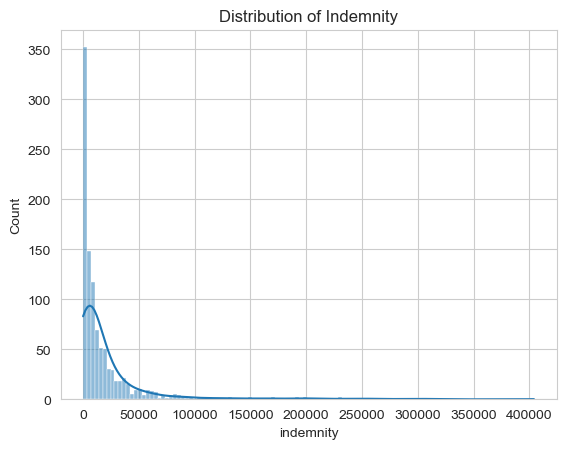

In [46]:
print('Indemnity values pre-standard deviation method outlier removal: ')
print(wr_cl['indemnity'].describe())

mean = wr_cl_orig['indemnity'].mean()
std_dev = wr_cl_orig['indemnity'].std()

# Define the outliers boundaries
lower_bound = max(0, mean - 2 * std_dev)  # it should not be less than 0
upper_bound = mean + 4 * std_dev

# Filter out the outliers
ol_wr_cl_std_rm = wr_cl_orig[(wr_cl_orig['indemnity'] >= lower_bound)
                                  & (wr_cl_orig['indemnity'] <= upper_bound)]

print('Indemnity values post-standard deviation method outlier removal: ')
print(ol_wr_cl_std_rm['indemnity'].describe())
print("\n")
# Create a histogram of the 'indemnity' column
sns.histplot(data=ol_wr_cl_std_rm, x='indemnity', kde=True)

plt.title('Distribution of Indemnity')
plt.show()

Indemnity values pre-percentile clip method outlier removal: 
count    1.079000e+03
mean     2.944987e+04
std      9.646561e+04
min     -8.339400e+04
25%      2.098250e+03
50%      7.306000e+03
75%      2.039600e+04
max      1.520491e+06
Name: indemnity, dtype: float64
Indemnity values post-percentile clip method outlier removal: 
count      1041.000000
mean      22597.521124
std       47823.286124
min           0.000000
25%        2270.000000
50%        7433.500000
75%       20344.000000
max      436223.500000
Name: indemnity, dtype: float64




<Axes: xlabel='indemnity', ylabel='Count'>

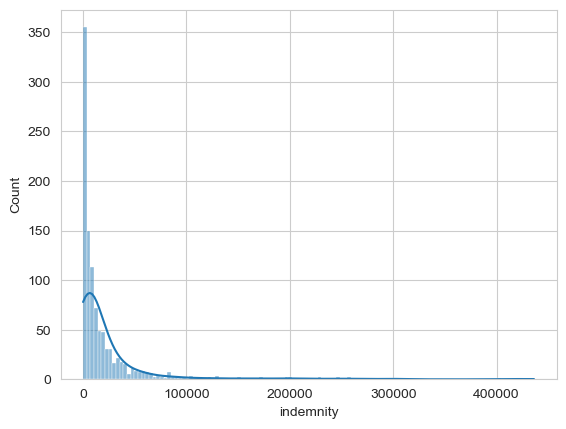

In [47]:

print('Indemnity values pre-percentile clip method outlier removal: ')
print(wr_cl['indemnity'].describe())

# Define the outliers boundaries
lower_bound = wr_cl_orig['indemnity'].quantile(0.01)
upper_bound = wr_cl_orig['indemnity'].quantile(0.99)

# Identify rows where 'indemnity' is within the desired range
within_bounds = (wr_cl_orig['indemnity'] >= 0) & (wr_cl_orig['indemnity'] <= upper_bound)

# Filter the original DataFrame
ol_wr_cl_clip = wr_cl_orig[within_bounds]

print('Indemnity values post-percentile clip method outlier removal: ')
print(ol_wr_cl_clip['indemnity'].describe())
print("\n")
# Create a histogram of the 'indemnity' column
sns.histplot(data=ol_wr_cl_clip, x='indemnity', kde=True)


Indemnity values pre-IQR method outlier removal: 
count    1.079000e+03
mean     2.944987e+04
std      9.646561e+04
min     -8.339400e+04
25%      2.098250e+03
50%      7.306000e+03
75%      2.039600e+04
max      1.520491e+06
Name: indemnity, dtype: float64
Indemnity values post-IQR method outlier removal: 
count      927.000000
mean     10012.432697
std      10724.412607
min          0.000000
25%       2005.400000
50%       6012.500000
75%      14443.750000
max      47327.000000
Name: indemnity, dtype: float64




<Axes: xlabel='indemnity', ylabel='Count'>

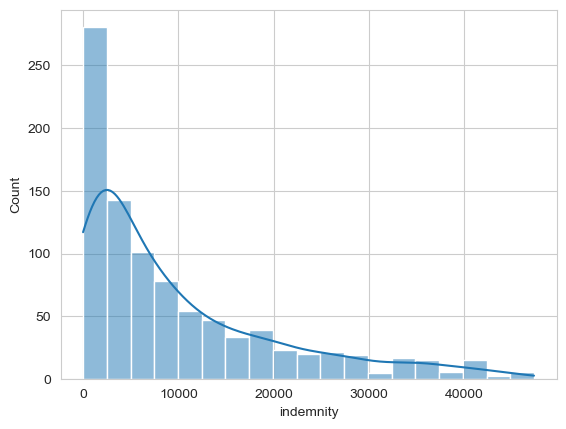

In [48]:
print('Indemnity values pre-IQR method outlier removal: ')
print(wr_cl_orig['indemnity'].describe())

Q1 = wr_cl_orig['indemnity'].quantile(0.25)
Q3 = wr_cl_orig['indemnity'].quantile(0.75)
IQR = Q3 - Q1

# Define the outliers boundaries
lower_bound = max(0, Q1 - 1.5 * IQR)  # it should not be less than 0
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
ol_wr_cl_iqr_rm = wr_cl_orig[(wr_cl_orig['indemnity'] >= lower_bound)
                                  & (wr_cl_orig['indemnity'] <= upper_bound)]

print('Indemnity values post-IQR method outlier removal: ')
print(ol_wr_cl_iqr_rm['indemnity'].describe())
print("\n")

# Create a histogram of the 'indemnity' column
sns.histplot(data=ol_wr_cl_iqr_rm, x='indemnity', kde=True)


In [49]:
# Save csv's
wr_cl_orig.to_csv(os.path.join(src_dir, 'crop_loss_COL/wr_cl.csv'), index=False)
ol_wr_cl_clip.to_csv(os.path.join(src_dir, 'crop_loss_COL/wr_cl_clip_filtered.csv'), index=False)
ol_wr_cl_iqr_rm.to_csv(os.path.join(src_dir, 'crop_loss_COL/wr_cl_IQR_filtered.csv'), index=False)
ol_wr_cl_std_rm.to_csv(os.path.join(src_dir, 'crop_loss_COL/wr_cl_std_filtered.csv'), index=False)

In [50]:
%who_ls

['CRS',
 'Dataset',
 'GeoDataFrame',
 'INLINE',
 'IQR',
 'LATITUDE_FORMATTER',
 'LONGITUDE_FORMATTER',
 'LineString',
 'Normalize',
 'Path',
 'Point',
 'Q1',
 'Q3',
 'abbrev_us_state_upper',
 'ax1',
 'bars',
 'calendar',
 'ccrs',
 'cf',
 'chardet',
 'cmap',
 'col',
 'color_values',
 'colors',
 'column_order',
 'columns_to_drop',
 'combine_csv_files',
 'combine_files',
 'cp1_wr_cl',
 'cp2_wr_cl',
 'datetime',
 'db4_wr_cl',
 'df',
 'df_gdf_or_csv_to_shp',
 'diffs',
 'directory',
 'display',
 'fig',
 'filter_col_des',
 'filter_df_extent',
 'from_origin',
 'gdf_buf',
 'get_crs',
 'glob',
 'gpd',
 'grouped_data',
 'hv',
 'hvplot',
 'index',
 'ksnesdnd_cl',
 'largest_gap_index',
 'largest_gap_value',
 'lower_bound',
 'mean',
 'millions',
 'min_nonzero',
 'month_name_to_number',
 'month_number_to_name',
 'mticker',
 'nc',
 'norm',
 'np',
 'numbers',
 'numbers_plus_one',
 'ol_wr_cl_clip',
 'ol_wr_cl_iqr_rm',
 'ol_wr_cl_std_rm',
 'os',
 'output_notebook',
 'pd',
 'plt',
 'print_all_imported_mod

In [52]:
%store src_dir
# %store extent_coords
%store wr_cl
%store ol_wr_cl_clip
%store ol_wr_cl_iqr_rm
%store ol_wr_cl_std_rm
# %store crop_cvr_gdf

Stored 'src_dir' (str)
Stored 'wr_cl' (DataFrame)
Stored 'ol_wr_cl_clip' (DataFrame)
Stored 'ol_wr_cl_iqr_rm' (DataFrame)
Stored 'ol_wr_cl_std_rm' (DataFrame)
